
# This is the draft notebook 

In [2]:
# import modules

import numpy as np
import pandas as pd # import library for data analysis

from get_regression_coefs_general import get_regression_coefs # import our function to get GDP trend

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns # for nicer plots (not essential)
sns.set_theme('talk', style = 'white')

import openpyxl
print(openpyxl.__version__)

3.1.5


In [3]:
# 2.1) Load dataset
data = pd.read_excel('pwt100.xlsx', sheet_name = 'Data', header = 0)

In [4]:
# 2.2) Clean data

# Subset relevant columns and compute per capita real GDP
# The .loc property is used for indexing; see here for more https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html
data = data.loc[:, ("country", "year", "rgdpe", "pop")]
data["rgdpe_pc"] = data["rgdpe"] / data["pop"]

# select Indonesia
data = data.loc[data["country"] == "Indonesia", ("year", "rgdpe_pc")]
# Reset the index (not crucial)
data = data.reset_index(drop = True)

# Calculate number of years before removing NaN values 
years_before = len(data)

# Filter out rows with missing values for per capita GDP
data = data.dropna(subset=["rgdpe_pc"])

# Calculate number of years after removing NaN values 
years_after = len(data)
years_removed = years_before - years_after

# Subset the RGDP per capita series
ymax = 2019
ymin = 1950
# We use logical indexing to subset the data to rows of years ymin <= year <= ymax
Y = data.loc[np.logical_and(data["year"] <= ymax, data["year"] >= ymin), "rgdpe_pc"]
y = np.log(Y)
data = data[data["year"] >= ymin] # we keep only years after ymin

# Compute separate sample sizes for the subsample used for estimation and the whole sample.
T = len(Y) # sample size used for regression
T_all = data["year"].max() - (ymin - 1) -years_removed # number of all years in the data after ymin that have data points
print(T)
print(T_all)

60
60


In [5]:
# 3.1) Additive Linear Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T
# The dependent variable is per capita GDP in *levels*

x1 = np.empty(T) # initialise an empty vector for the first regressor
x2 = np.empty(T) # initialise an empty vector for the second regressor

for t in range(T):
    x1[t] = 1.
    x2[t] = t + 1 # recall that Python starts indexing at 0

a_add_lin, b_add_lin = get_regression_coefs(Y, x1, x2)
print(a_add_lin)
print(b_add_lin)

# Initialise predicted values yhat
Yhat_add_lin = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_add_lin[t] = a_add_lin + b_add_lin * (t + 1) # recall that Python indexing starts at 0
 
# Let us convert into log-units
yhat_add_lin = np.log(Yhat_add_lin)

-907.3683373348603
165.13517170640046


/var/folders/nb/qqsy40314xbct2_kp_vkmm0h0000gn/T/ipykernel_1564/402300518.py:24: RuntimeWarning: invalid value encountered in log
  yhat_add_lin = np.log(Yhat_add_lin)


In [6]:
# 3.2) Additive Quadratic Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T, third regressor x3 is the vector 1, 4, ..., T^2
# The dependent variable is per capita GDP in *levels*
x3 = x2 ** 2

a_add_quad, b1_add_quad, b2_add_quad = get_regression_coefs(Y, x1, x2, x3)

print(a_add_quad)
print(b1_add_quad)
print(b2_add_quad)

# Initialise predicted values yhat
Yhat_add_quad = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_add_quad[t] = a_add_quad + b1_add_quad * (t + 1) + b2_add_quad * (t + 1) ** 2

# Take the natural logarithm of the shifted fitted values
yhat_add_quad = np.log(Yhat_add_quad)

1442.3468159633373
-62.25661732245501
3.7277342463746734


In [7]:
# 3.3) Exponential Linear Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T
# The dependent variable is per capita GDP in *ln*
y_exp_lin = np.log(Y)

a_exp_lin, b_exp_lin = get_regression_coefs(y_exp_lin, x1, x2)

# Initialise predicted values yhat
yhat_exp_lin = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    yhat_exp_lin[t] = a_exp_lin + b_exp_lin * (t + 1)
print(yhat_exp_lin)

[6.73290874 6.77708469 6.82126065 6.8654366  6.90961255 6.95378851
 6.99796446 7.04214041 7.08631637 7.13049232 7.17466827 7.21884423
 7.26302018 7.30719614 7.35137209 7.39554804 7.439724   7.48389995
 7.5280759  7.57225186 7.61642781 7.66060377 7.70477972 7.74895567
 7.79313163 7.83730758 7.88148353 7.92565949 7.96983544 8.0140114
 8.05818735 8.1023633  8.14653926 8.19071521 8.23489116 8.27906712
 8.32324307 8.36741903 8.41159498 8.45577093 8.49994689 8.54412284
 8.58829879 8.63247475 8.6766507  8.72082666 8.76500261 8.80917856
 8.85335452 8.89753047 8.94170642 8.98588238 9.03005833 9.07423429
 9.11841024 9.16258619 9.20676215 9.2509381  9.29511405 9.33929001]


In [8]:
# 3.4) Exponential Quadratic Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T, third regressor x3 is the vector 1, 4, ..., T^2
# The dependent variable is per capita GDP in *ln*
x3 = x2 ** 2

a_exp_quad, b1_exp_quad, b2_exp_quad = get_regression_coefs(y_exp_lin, x1, x2, x3)

# Initialise predicted values yhat
yhat_exp_quad = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    yhat_exp_quad[t] = a_exp_quad + b1_exp_quad * (t + 1) + b2_exp_quad * (t + 1) ** 2

print(yhat_exp_quad)

[6.73312064 6.77727504 6.82143019 6.86558608 6.90974271 6.95390009
 6.99805821 7.04221707 7.08637668 7.13053703 7.17469812 7.21885996
 7.26302254 7.30718586 7.35134992 7.39551473 7.43968028 7.48384657
 7.52801361 7.57218139 7.61634991 7.66051918 7.70468919 7.74885994
 7.79303144 7.83720368 7.88137666 7.92555038 7.96972485 8.01390006
 8.05807601 8.10225271 8.14643015 8.19060833 8.23478726 8.27896693
 8.32314734 8.3673285  8.41151039 8.45569304 8.49987642 8.54406055
 8.58824542 8.63243103 8.67661739 8.72080449 8.76499233 8.80918092
 8.85337025 8.89756032 8.94175113 8.98594269 9.03013499 9.07432804
 9.11852182 9.16271635 9.20691163 9.25110764 9.2953044  9.33950191]


Text(0.5, 1.0, 'Exponential: GDP & trend')

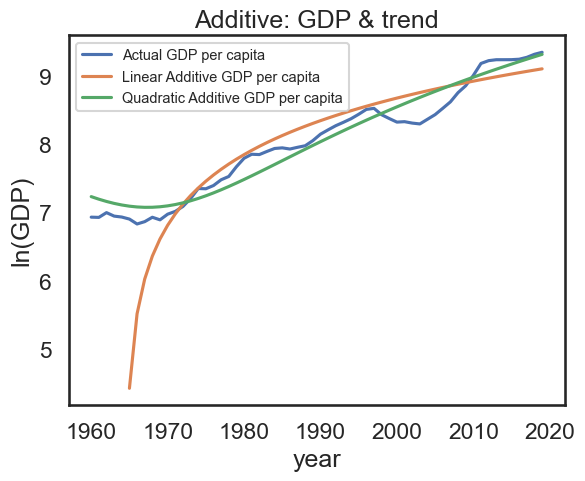

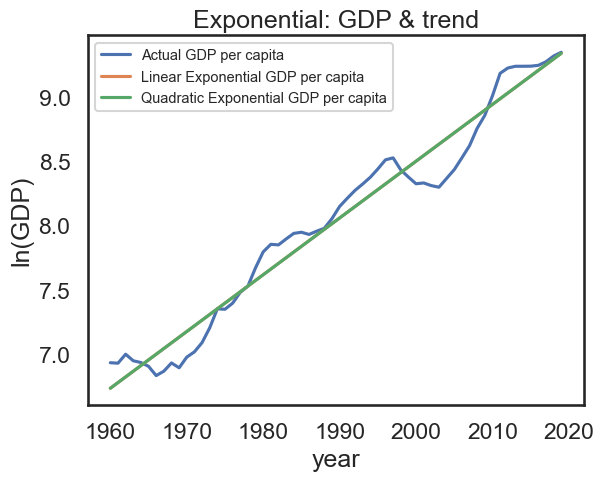

In [9]:
lw = 4

#Plot Additive Graph
plt.figure()
plt.plot(data['year'],np.log(data['rgdpe_pc']), label="Actual GDP per capita")
plt.plot(data['year'],yhat_add_lin, label="Linear Additive GDP per capita")
plt.plot(data['year'],yhat_add_quad, label="Quadratic Additive GDP per capita")

#labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Additive: GDP & trend")

#Plot Exponential Graph 
plt.figure()
plt.plot(data['year'],np.log(data['rgdpe_pc']), label="Actual GDP per capita")
plt.plot(data['year'],yhat_exp_lin, label="Linear Exponential GDP per capita")
plt.plot(data['year'],yhat_exp_quad, label="Quadratic Exponential GDP per capita")

#labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Exponential: GDP & trend")

,year,rgdpna,emp,rnna,hc,TFP_alpha_0.25,TFP_alpha_0.3,TFP_alpha_0.35
0,1960,1.475389e+05,28.498953,7.623768e+05,1.158581,2584.620672,2210.380296,1845.382708
1,1961,1.596486e+05,29.060551,7.653232e+05,1.176857,2768.498671,2384.611743,2007.325066
2,1962,1.594061e+05,29.569380,7.644622e+05,1.195421,2674.185813,2303.290030,1938.785826
3,1963,1.532446e+05,30.088734,7.563245e+05,1.214278,2463.517674,2116.045162,1775.561034
4,1964,1.603702e+05,30.618654,7.516056e+05,1.233432,2537.466753,2190.323887,1848.360916
5,1965,1.622570e+05,31.159178,7.476065e+05,1.252888,2497.746395,2159.537477,1825.794865
6,1966,1.667850e+05,31.710342,7.471328e+05,1.272652,2507.069386,2173.418853,1843.225704
7,1967,1.690491e+05,32.272175,7.406710e+05,1.292727,2476.321898,2151.300857,1828.918223
8,1968,1.807467e+05,32.844719,7.435955e+05,1.313118,2615.444282,2285.829922,1956.780513
9,1969,1.818787e+05,33.427994,7.511329e+05,1.333832,2542.487892,2221.255068,1900.698727


Text(0.5, 1.0, 'Time Series of TFP')

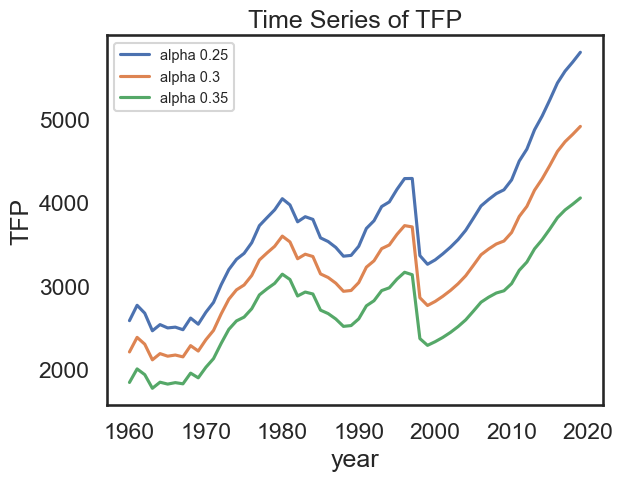

In [10]:
# Part B, calculating TFP 
# Load dataset
data = pd.read_excel('pwt100.xlsx', sheet_name='Data', header=0)

# Extract relevant variables in production function and select Indonesia
data_indonesia_b = data.loc[data["country"] == "Indonesia", ["year", "rgdpna", "emp", "rnna", "hc"]]

# Drop rows with missing values in specified columns
data_indonesia_b.dropna(subset=["rgdpna", "emp", "rnna", "hc"], inplace=True)

# Define a list of alpha values for robustness check
alpha_values = [0.25, 0.3, 0.35]

# Calculate TFP for each alpha and store the results in a dictionary
tfp_results = {}

for alpha in alpha_values:
    tfp = (1/(data_indonesia_b["emp"]*data_indonesia_b["hc"]))*(data_indonesia_b["rgdpna"]/(data_indonesia_b["rnna"])**alpha)**(1/(1-alpha))
    tfp_results[f"TFP_alpha_{alpha}"] = tfp

# Convert the results dictionary to a DataFrame for better visualization
tfp_df = pd.DataFrame(tfp_results)

# Add the year column for reference
tfp_df["year"] = data_indonesia_b["year"]

# Merge the TFP DataFrame with the original Indonesia DataFrame
data_indonesia_b = data_indonesia_b.merge(tfp_df, on="year")

# Display the updated DataFrame
display(data_indonesia_b)

#Plot Time Series
plt.figure()
plt.plot(data_indonesia_b['year'],data_indonesia_b["TFP_alpha_0.25"], label="alpha 0.25")
plt.plot(data_indonesia_b['year'],data_indonesia_b["TFP_alpha_0.3"], label="alpha 0.3")
plt.plot(data_indonesia_b['year'],data_indonesia_b["TFP_alpha_0.35"], label="alpha 0.35")

#labels
plt.xlabel("year")
plt.ylabel("TFP")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Time Series of TFP")

In [11]:
# Part C, Growth Accounting
# Ensure the year column is of integer type
data_indonesia_b["year"] = data_indonesia_b["year"].astype(int)

# Create a new column 'hL' that is labour multiplied by hc
data_indonesia_b["hL"] = data_indonesia_b["emp"] * data_indonesia_b["hc"]

# Display the updated DataFrame
display(data_indonesia_b.head())

# Initialise dataframe with NaNs
avg_growth_rates = pd.DataFrame(
    data = np.full((6, 4), np.nan),
    columns = ['Y growth', 'K growth', 'hL growth', 'A growth']
)
avg_growth_rates['year'] = ["1960-1970", "1970-1980", "1980-1990", "1990-2000", "2000-2010", "2010-2019"]
avg_growth_rates = avg_growth_rates.set_index('year')

# Set alpha = 0.3 
alpha = 0.3 

# Fill with average growth rates from data_indonesia_b
cols = ['rgdpna', 'rnna', 'hL', 'TFP_alpha_0.3']

# Ensure the years exist in the DataFrame
years = [1960, 1970, 1980, 1990, 2000, 2010, 2019]
for start, end in zip(years[:-1], years[1:]):
    if start in data_indonesia_b["year"].values and end in data_indonesia_b["year"].values:
        avg_growth_rates.loc[f"{start}-{end}"] = np.log(data_indonesia_b.loc[data_indonesia_b["year"] == end, cols].values / data_indonesia_b.loc[data_indonesia_b["year"] == start, cols].values).flatten()

# Compute contribution rates
df_contribs_long = avg_growth_rates.copy()
df_contribs_long['K contribution'] = alpha * (df_contribs_long['K growth'] / df_contribs_long['Y growth'])
df_contribs_long['hL contribution'] = (1 - alpha) * (df_contribs_long['hL growth'] / df_contribs_long['Y growth'])
df_contribs_long['A contribution'] = (1 - alpha) * (df_contribs_long['A growth'] / df_contribs_long['Y growth'])

# Only keep selected columns
df_contribs_long = df_contribs_long[['Y growth', 'K contribution', 'hL contribution', 'A contribution']]

display(df_contribs_long)

,year,rgdpna,emp,rnna,hc,TFP_alpha_0.25,TFP_alpha_0.3,TFP_alpha_0.35,hL
0,1960,147538.921875,28.498953,762376.7500,1.158581,2584.620672,2210.380296,1845.382708,33.018356
1,1961,159648.609375,29.060551,765323.1875,1.176857,2768.498671,2384.611743,2007.325066,34.200116
2,1962,159406.125000,29.569380,764462.1875,1.195421,2674.185813,2303.290030,1938.785826,35.347857
3,1963,153244.640625,30.088734,756324.5000,1.214278,2463.517674,2116.045162,1775.561034,36.536083
4,1964,160370.234375,30.618654,751605.5625,1.233432,2537.466753,2190.323887,1848.360916,37.766030


,Y growth,K contribution,hL contribution,A contribution
year,,,,
1960-1970,0.281279,0.010385,0.830335,0.159280
1970-1980,0.767951,0.245765,0.368947,0.385288
1980-1990,0.608867,0.383940,0.809124,-0.193064
1990-2000,0.413341,0.521737,0.608869,-0.130606
2000-2010,0.510038,0.280599,0.366725,0.352676
2010-2019,0.466961,0.344177,0.207251,0.448572


,year,labour_productivity
0,1960,5176.994487
1,1961,5493.653960
2,1962,5390.918783
3,1963,5093.090400
4,1964,5237.664368
5,1965,5207.356698
6,1966,5259.641941
7,1967,5238.231084
8,1968,5503.067434
9,1969,5440.910861


Text(0.5, 1.0, 'Time Series of TFP and Labour Productivity')

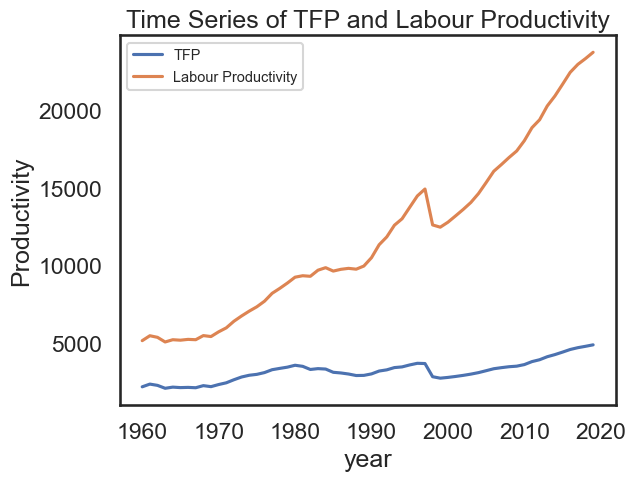

In [12]:
# Part D, Labour Productivity 
# Calculate labor productivity (GDP per worker)
data_indonesia_b["labour_productivity"] = data_indonesia_b["rgdpna"] / data_indonesia_b["emp"]

# Display the updated DataFrame
display(data_indonesia_b[["year", "labour_productivity"]])

#Plot Time Series
plt.figure()
plt.plot(data_indonesia_b['year'],data_indonesia_b["TFP_alpha_0.3"], label="TFP")
plt.plot(data_indonesia_b['year'],data_indonesia_b["labour_productivity"], label="Labour Productivity")

#labels
plt.xlabel("year")
plt.ylabel("Productivity")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Time Series of TFP and Labour Productivity")
